In [3]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers
from functools import partial
from sklearn.utils import shuffle

pd.set_option('display.max_rows', None)

What is the lower bound for the number of training examples, N?
- N >= n
- lower bound is amount of rbf kernels n

What happens with the error if N = n? Why?
- if we have as many rbf kernels n as samples N then we are overfitting, each rbf kernel can select one sample as its prototype vector and the error is 0

Under what conditions, if any, does (4) have a solution in this case?
- ??

During training we use an error measure defined over the training examples. Is it good to use this measure when evaluating the performance of the network? Explain!
- No, because we don't get information about the generalization error.
- We do not notice if we overfit or not, if we do not use validation / test sets.


# 3.1 Supervised learning of RBF NN

In [4]:
def sin_function(x):
    return np.sin(2 * x).reshape(-1, 1)


def square_function(x):
    a = (np.sin(2 * x) >= 0).astype(float).reshape(-1, 1)
    a[a == 0] = -1
    return a


def generate_X(start=0, stop=2 * np.pi, step_size=0.1):
    return np.arange(start, stop, step_size).reshape(-1, 1)


def get_train_data(noise=False):
    X_train = generate_X()
    y_train_sin = sin_function(X_train)
    y_train_square = square_function(X_train)

    if noise:
        X_train += np.random.normal(0, 0.1, (len(X_train), 1))
        y_train_sin += np.random.normal(0, 0.1, (len(X_train), 1))
        y_train_square += np.random.normal(0, 0.1, (len(X_train), 1))

    return X_train, y_train_sin, y_train_square


def get_test_data(noise=False):
    X_test = generate_X(start=0.05)
    y_test_sin = sin_function(X_test)
    y_test_square = square_function(X_test)

    if noise:
        X_test += np.random.normal(0, 0.1, (len(X_test), 1))
        y_test_sin += np.random.normal(0, 0.1, (len(X_test), 1))
        y_test_square += np.random.normal(0, 0.1, (len(X_test), 1))

    return X_test, y_test_sin, y_test_square


def get_rbf_kernels(num, std=0.1):
    number_of_kernel = num

    rbf_center_sin = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_sin = sin_function(rbf_center_sin)

    rbf_center_square = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_square = square_function(rbf_center_square)

    kernel_stds = std * np.ones((len(rbf_center_square),)).reshape(-1, 1)

    return kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square


X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(10)

residual_error_thresholds = [0.1, 0.01, 0.001]

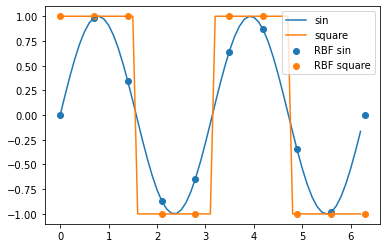

In [5]:
plt.plot(X_train, y_train_sin, label="sin")
plt.plot(X_train, y_train_square, label="square")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF sin")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF square")
plt.legend()
plt.show()


In [6]:

def plot_rbf_with_data(rbf, X, y):
    y_pred = rbf.predict(X)

    plt.plot(X, y, label="Sin")
    plt.scatter(rbf.kernel_centers, [0] * len(rbf.kernel_centers), label="RBF")
    plt.plot(X, y_pred, label="Pred")
    plt.legend()
    plt.show()


In [28]:
class RBFNet:
    def __init__(self, kernel_centers=None, kernel_stds=None, k=None,
                 delta_lr=0.1, cl_lr=0.3, delta_epochs=200, cl_epochs=100):
        self.delta_lr = delta_lr
        self.cl_lr = cl_lr
        self.delta_epochs = delta_epochs
        self.cl_epochs = cl_epochs
        self.kernel_centers = kernel_centers
        self.kernel_stds = kernel_stds
        if kernel_centers is None:
            self.k = k
        else:
            self.k = len(kernel_centers)
        self.w = self.init_weights()
        self.patience = 10
        self.delta_threshold = 0.0001
        self.loss_history = []

    def rbf_function(self, x, center, std):
        return np.exp(-((x - center) ** 2) / (2 * std ** 2))

    def calc_expanded_X(self, X):
        if np.ndim(np.squeeze(X)) == 0:
            phi = np.array(
                [self.rbf_function(np.squeeze(X), c, s) for c, s, in
                 zip(self.kernel_centers, self.kernel_stds)]).reshape(-1, 1)
            assert phi.shape == (self.k, 1)
            return phi

        rows = []
        for i in range(X.shape[0]):
            row = [self.rbf_function(X[i], c, s) for c, s, in zip(self.kernel_centers, self.kernel_stds)]
            rows.append(row)
        phi = np.hstack(rows).T  # vstack does not work :((((((((
        assert phi.shape == (X.shape[0], self.k)
        return phi

    def forward_pass(self, X):
        phi = self.calc_expanded_X(X)
        if phi.shape == (self.k, 1):  #might produce error if samples = k
            return phi.T @ self.w
        return phi @ self.w

    def sum_of_squared_diff(self, y_pred, y_true):
        return np.sum((y_pred - y_true) ** 2)

    def mean_absolute_error(self, y_pred, y_true):
        return 1 / len(y_pred) * np.sum(np.abs(y_pred - y_true))

    def perceptron_batch_learning(self, X, y):
        phi = self.calc_expanded_X(X)
        inv_cov = np.linalg.inv(phi.T @ phi)
        self.w = inv_cov @ phi.T @ y
        assert self.w.shape == (self.k, 1)

    def delta_online_learning(self, X, y):  # sequential
        X, y = shuffle(X, y)

        for i in range(len(X)):
            _x, _y = np.squeeze(X[i, :]), np.squeeze(y[i, :])
            error = np.squeeze(_y - self.forward_pass(_x))
            if np.ndim(np.squeeze(error)) == 0:
                w_delta = self.delta_lr * error * self.calc_expanded_X(_x)
            else:
                w_delta = self.delta_lr * error @ self.calc_expanded_X(_x)
            assert w_delta.shape == (self.k, 1)
            self.w += w_delta

        assert self.w.shape == (self.k, 1)

    def init_weights(self):
        self.w = np.random.randn(self.k, 1)

    def fit(self, X, y, rule="perceptron", cl=None, vanilla=False):
        # init
        if self.kernel_centers is None:
            if cl is None:
                self.init_random_prototype_vectors(X, vanilla)
            else:
                self.init_rbf_kernels_with_cl(X, cl, vanilla)
        self.init_weights()

        self.loss_history = []

        # learn
        patience = self.patience
        last_error = np.inf
        if rule == "delta":
            for epoch in range(self.delta_epochs):
                self.delta_online_learning(X, y)

                # abort if converged
                new_error = self.evaluate_residual_error(X, y)
                self.loss_history.append(new_error)
                diff = last_error - new_error
                if diff <= 0 or diff < self.delta_threshold:
                    # worse or small change -> stop if we did not improve over patience epochs
                    patience -= 1
                else:
                    patience = self.patience

                if patience <= 0:
                    print(f"Converged at epoch {epoch}")
                    break
                last_error = new_error
        else:
            self.perceptron_batch_learning(X, y)

        print("After Train - Error: ", self.evaluate_residual_error(X, y))

    def predict(self, X, sign=False):
        y_pred = self.forward_pass(X)
        if sign:
            y_pred = np.sign(y_pred)
        return y_pred

    def fit_and_predict(self, X, y, rule="perceptron", cl=None, sign=False):
        self.fit(X, y, rule, cl)
        return self.predict(X, sign)

    def evaluate_residual_error(self, X, y, sign=False):
        y_pred = self.predict(X, sign)
        return self.mean_absolute_error(y_pred, y)

    def init_rbf_kernels_with_cl(self, X, mode="hard", vanilla=False):
        self.init_random_prototype_vectors(X, vanilla)

        for epoch in range(self.cl_epochs):
            if mode == "hard":
                for _ in X:
                    rnd_sample = X[np.random.randint(len(X))]
                    winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                    self.update_winner(winner_index, rnd_sample)

            else:  # soft
                for _ in X:
                    rnd_sample = X[np.random.randint(len(X))]
                    winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                    self.update_neighborhood_of(winner_index, rnd_sample, epoch)

        self.init_kernel_stds(X, vanilla)

    def update_winner(self, winner_index, rnd_sample, factor=1):
        # update prototype vector
        delta = self.cl_lr * factor * (rnd_sample - self.kernel_centers[winner_index])
        self.kernel_centers[winner_index] += delta

    def update_neighborhood_of(self, winner_index, rnd_sample, epoch):
        winner = self.kernel_centers[winner_index]  #, :
        dist = np.sum((self.kernel_centers - winner) ** 2, axis=1)
        assert dist.shape == (self.k,)

        factors = np.array([self.neighborhood_function(d, epoch) for d in dist])
        factors = factors / sum(factors)
        assert factors.shape == (self.k,)

        for kernel_i in range(self.k):
            self.update_winner(kernel_i, rnd_sample, factors[kernel_i])

    def neighborhood_function(self, distance, epoch):
        return np.exp(- (distance ** 2) / (2 * self.calc_sigma(epoch) ** 2))

    def calc_sigma(self, epoch, sigma_0=0.2):
        return sigma_0 * np.exp(- epoch ** 2 / self.cl_epochs)  # epoch ~linear or epoch ** 2 ~straight down

    def get_index_nearest_rbf_kernel(self, sample):
        dist = np.sum((self.kernel_centers - sample) ** 2, axis=1)
        assert dist.shape == (self.k,)
        min_index = np.argmin(dist)
        return min_index

    def init_random_prototype_vectors(self, X, vanilla=False):
        if vanilla:
            self.kernel_centers = np.random.uniform(low=np.min(X), high=np.max(X), size=(self.k, 1))
        else:
            rnd_samples = X[np.random.randint(low=len(X), size=self.k)]
            self.kernel_centers = rnd_samples
        self.init_kernel_stds(X, vanilla)

    def nearest_kernel(self, X):
        distances = np.squeeze(np.abs(X[:, np.newaxis] - self.kernel_centers[np.newaxis, :]))
        closest_kernel = np.argmin(distances, axis=1)
        return closest_kernel

    def init_kernel_stds(self, X, vanilla=False):
        fix_stds = False
        stds = []
        closest_kernels = self.nearest_kernel(X)

        for i in range(self.k):
            points_for_kernel = X[closest_kernels == i]
            if len(points_for_kernel) >= 2:
                std = np.std(X[closest_kernels == i])
                stds.append(std)
            else:
                fix_stds = True
                stds.append(0)

        stds = np.array(stds).reshape(-1, )

        if fix_stds and not vanilla:
            # set clusters with std = 0 to mean std of other kernels
            mean = np.mean(stds[stds != 0])
            stds[stds == 0] = mean

        self.kernel_stds = stds * 3


Kernels 1
After Train - Error:  0.9732061934491242

Kernels 2
After Train - Error:  0.9550379936354377

Kernels 3
After Train - Error:  0.954761703435117

Kernels 4
After Train - Error:  0.8684508872309861

Kernels 5
After Train - Error:  0.9478272979296297

Kernels 6
After Train - Error:  0.7872617993651992

Kernels 7
After Train - Error:  0.7865339196237687

Kernels 8
After Train - Error:  0.6962917901158868

Kernels 9
After Train - Error:  0.7783946415148549

Kernels 10
After Train - Error:  0.6242773479637426

Kernels 11
After Train - Error:  0.6177878076708156

Kernels 12
After Train - Error:  0.5412604124297814

Kernels 13
After Train - Error:  0.6113466160382005

Kernels 14
After Train - Error:  0.48160456058568407

Kernels 15
After Train - Error:  0.4530159713448804

Kernels 16
After Train - Error:  0.384570527139329

Kernels 17
After Train - Error:  0.4388531800349614

Kernels 18
After Train - Error:  0.34230360537090665

Kernels 19
After Train - Error:  0.29921814597864343

K

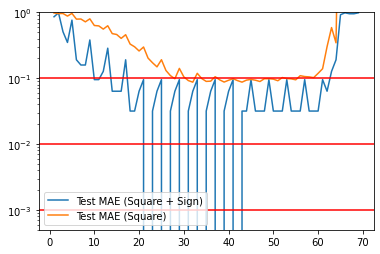

In [27]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1, 70, 1)
square_sign_maes = []
square_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
    y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, sign=True)

    square_sign_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)
    square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=False)

    square_sign_maes.append(square_sign_test_loss)
    square_maes.append(square_test_loss)
    print("")

best_k_square = np.argmin(square_maes)
print("Best", best_k_square, square_maes[best_k_square])

plt.plot(num_of_kernels, square_sign_maes, label="Test MAE (Square + Sign)")
plt.plot(num_of_kernels, square_maes, label="Test MAE (Square)")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


After Train - Error:  0.08640251560047767


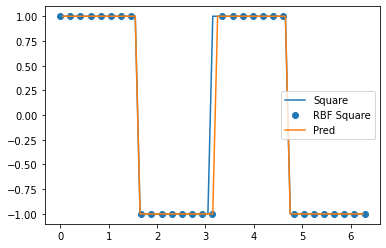

In [28]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_square)

rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, sign=True)

square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)

y_pred_test = rbf_square.predict(X_test, sign=True)

plt.plot(X_test, y_test_square, label="Square")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF Square")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


Kernels 1
After Train - Error:  0.6353058990904036

Kernels 2
After Train - Error:  0.6329373979433681

Kernels 3
After Train - Error:  0.6329373979265401

Kernels 4
After Train - Error:  0.5589151555129263

Kernels 5
After Train - Error:  0.6329373977450057

Kernels 6
After Train - Error:  0.5041152521705397

Kernels 7
After Train - Error:  0.4872983762665598

Kernels 8
After Train - Error:  0.4565461493554236

Kernels 9
After Train - Error:  0.46380801823531825

Kernels 10
After Train - Error:  0.40686379222951224

Kernels 11
After Train - Error:  0.3793826118273995

Kernels 12
After Train - Error:  0.3550645871508203

Kernels 13
After Train - Error:  0.34329549005466026

Kernels 14
After Train - Error:  0.3043432716950079

Kernels 15
After Train - Error:  0.28089806600228434

Kernels 16
After Train - Error:  0.24950540152658907

Kernels 17
After Train - Error:  0.22958317739560233

Kernels 18
After Train - Error:  0.20355724421959479

Kernels 19
After Train - Error:  0.1756879868153

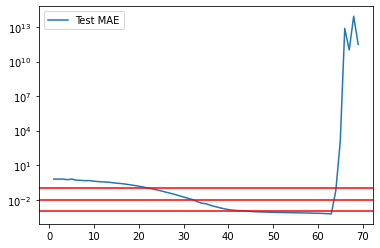

In [29]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1, 70, 1)
sin_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
    y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

    sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)

    sin_maes.append(sin_test_loss)
    print("")

best_k_sin = np.argmin(sin_maes)
print("Best", best_k_sin, sin_maes[best_k_sin])

plt.plot(num_of_kernels, sin_maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


After Train - Error:  6.30738176623097e-06


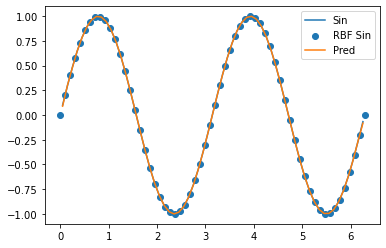

In [30]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_sin)

rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)
y_pred_test = rbf_sin.predict(X_test)

plt.plot(X_test, y_test_sin, label="Sin")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF Sin")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


How can you simply transform the output of your RBF network to reduce the residual error to 0 for the square(2x) problem? Still, how many units do you need? In what type of applications could this transform be particularly useful?
- sign activation function to {-1, 1}
- classification
- 30 units for test set residual error = 0


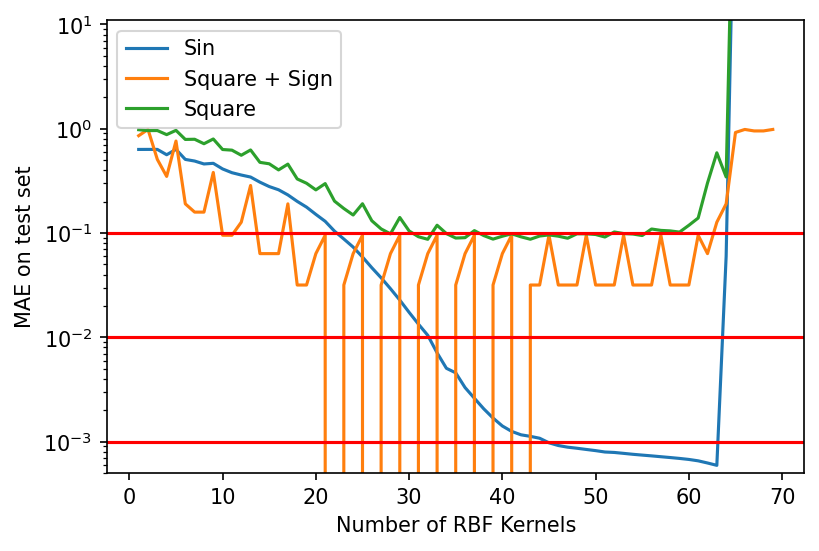

In [37]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(num_of_kernels, sin_maes, label="Sin")
plt.plot(num_of_kernels, square_sign_maes, label="Square + Sign")
plt.plot(num_of_kernels, square_maes, label="Square")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 11)
#plt.yticks([0.1, 0.01, 0.001])
plt.xlabel("Number of RBF Kernels")
plt.ylabel("MAE on test set")
plt.legend()
plt.show()


# 3.2 Regression with noise AND ONLINE

In [ ]:

X_train, y_train_sin, y_train_square = get_train_data(noise=1)
X_test, y_test_sin, y_test_square = get_test_data(noise=1)

num_of_kernels = np.arange(1, 66, 1)
sin_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
    y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin, rule="delta")

    sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)

    sin_maes.append(sin_test_loss)
    print("")

Best 30 0.1602646364678677


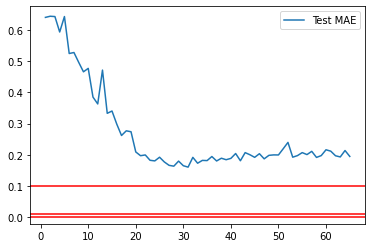

In [50]:

best_k_sin_noise = np.argmin(sin_maes)
print("Best", best_k_sin_noise, sin_maes[best_k_sin_noise])

plt.plot(num_of_kernels, sin_maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
#plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Converged at epoch 58
After Train - Error:  0.017938203876703595


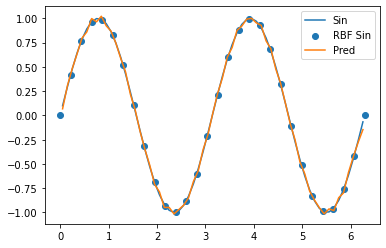

In [51]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_sin_noise)

rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin, rule="delta")

sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)
y_pred_test = rbf_sin.predict(X_test)

plt.plot(X_test, y_test_sin, label="Sin")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF Sin")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


# 3.3 Competitive learning to initialize RBF

In [44]:
noise = False

After Train - Error:  0.020508212846731065
After Train - Error:  0.008105612801291719


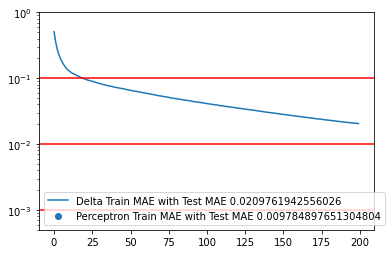

In [57]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

# Delta
rbf_vq_d = RBFNet(k=30, delta_epochs=200, cl_epochs=200)
y_pred_sin = rbf_vq_d.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")
mae_d = rbf_vq_d.evaluate_residual_error(X_test, y_test_sin)

# Perceptron
rbf_vq_p = RBFNet(k=30, delta_epochs=1, cl_epochs=200)
y_pred_sin = rbf_vq_p.fit_and_predict(X_train, y_train_sin, rule="perceptron", cl="hard")
mae_p = rbf_vq_p.evaluate_residual_error(X_test, y_test_sin)


#print("Mean", maes, "Std", std)

plt.plot(range(len(rbf_vq_d.loss_history)), rbf_vq_d.loss_history, label=f"Delta Train MAE with Test MAE {mae_d}")
plt.scatter(range(len(rbf_vq_p.loss_history)), rbf_vq_p.loss_history, label=f"Perceptron Train MAE with Test MAE {mae_p}")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Converged at epoch 92


,0
0.047785,5.045262
0.315113,4.383375
0.329985,6.059903
0.434226,1.822332
0.296001,4.740343
0.314449,2.825051
0.296001,4.931506
0.479563,0.527742
0.259577,2.386245
0.110136,5.220955


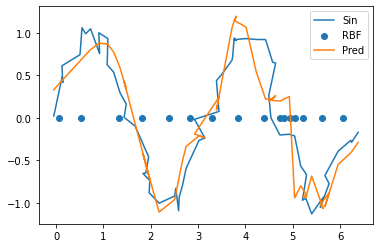

In [154]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=best_k_sin_cl, delta_epochs=200, cl_epochs=200)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)


In [148]:
noise = True

Kernels 1
Kernels 2
Loss: 27.2099
Residual Error (MAE): 0.5638

Kernels 3
Loss: 20.4888
Residual Error (MAE): 0.4600

Kernels 4
Loss: 10.7050
Residual Error (MAE): 0.3398

Kernels 5
Loss: 8.8039
Residual Error (MAE): 0.2690

Kernels 6
Loss: 6.3274
Residual Error (MAE): 0.2560

Kernels 7
Loss: 4.0577
Residual Error (MAE): 0.2090

Kernels 8
Loss: 3.0249
Residual Error (MAE): 0.1675

Kernels 9
Loss: 2.1129
Residual Error (MAE): 0.1707

Kernels 10
Loss: 2.6535
Residual Error (MAE): 0.1947

Kernels 11
Kernels 12
Loss: 1.2140
Residual Error (MAE): 0.1600

Kernels 13
Loss: 1.8798
Residual Error (MAE): 0.1624

Kernels 14
Loss: 1.2091
Residual Error (MAE): 0.1600

Kernels 15
Loss: 1.0063
Residual Error (MAE): 0.1456

Kernels 16
Kernels 17
Loss: 0.9461
Residual Error (MAE): 0.1425

Kernels 18
Loss: 1.4683
Residual Error (MAE): 0.1680

Kernels 19
Loss: 1.8129
Residual Error (MAE): 0.1702

Kernels 20
Loss: 0.9080
Residual Error (MAE): 0.1466

Kernels 21
Loss: 1.1237
Residual Error (MAE): 0.1592

K

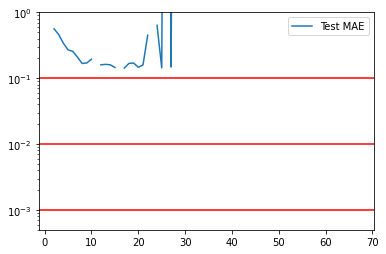

In [149]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

num_of_kernels = np.arange(1, 70, 1)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    try:
        rbf_vq = RBFNet(k=k, delta_epochs=200, cl_epochs=200)

        y_pred_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

        mae = rbf_vq.evaluate_residual_error(X_test, y_test_sin)

        maes.append(mae)
        print("")
    except:
        maes.append(np.inf)

best_k_sin_cl = np.argmin(maes)
print("Best", best_k_sin_cl, maes[best_k_sin_cl])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()

Loss: 1.7443
Residual Error (MAE): 0.1462


,0
0.364460,0.914034
0.383179,1.803822
0.260100,4.677686
0.205916,6.112834
0.345372,4.999340
0.080983,0.638821
0.314233,2.716520
0.290597,3.614516
0.026760,3.995403
0.408910,0.236615


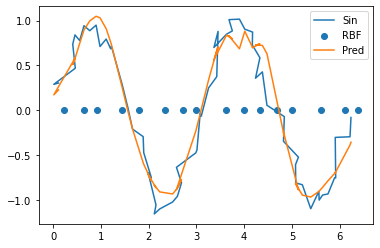

In [150]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=best_k_sin_cl, delta_epochs=200, cl_epochs=200)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)

Compare approaches
- VQ Prototype vectors become evenly space, similar to hand-picked vectors
    - VQ initialization is not as good as hand-picked
- Noise reduces performance
- Applying early stopping for both learning procedures might help
- Generalization
    - VQ is worse or better?


# 3.3.2 Soft winner

In [9]:
noise = False

Converged at epoch 234
After Train - Error:  0.029443782156586887


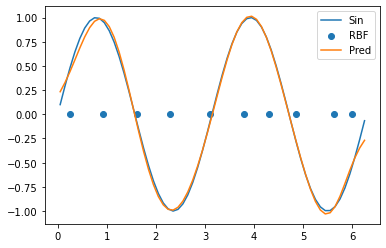

Converged at epoch 345
After Train - Error:  0.021921605705862424


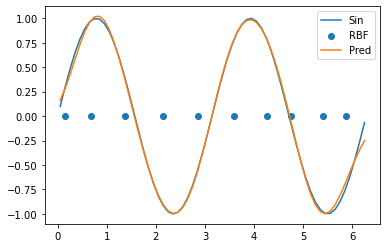

In [30]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

# good
rbf_vq = RBFNet(k=10, delta_epochs=500, cl_epochs=200)
y_pred_sin = rbf_vq.fit(X_train, y_train_sin, rule="delta", cl="hard", vanilla=False)
mae = rbf_vq.evaluate_residual_error(X_test, y_test_sin)

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)

# vanilla
rbf_vq_vanilla = RBFNet(k=10, delta_epochs=500, cl_epochs=200)
y_pred_sin_vanilla = rbf_vq_vanilla.fit(X_train, y_train_sin, rule="delta", cl="hard", vanilla=True)
mae_vanilla = rbf_vq_vanilla.evaluate_residual_error(X_test, y_test_sin)

plot_rbf_with_data(rbf_vq_vanilla, X_test, y_test_sin)


[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
 0.00000000e+000 4.56155821e-046 0.00000000e+000 1.00000000e+000
 8.75281014e-213 6.75911459e-128 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]
[2.64603779e-036 0.00000000e+000 0.00000000e+000 1.74935542e-027
 0.00000000e+000 1.00000000e+000 0.00000000e+000 1.74935542e-027
 5.97602290e-003 4.57833362e-001 0.00000000e+000 1.21128785e-152
 3.14508801e-289 0.00000000e+000 3.12711698e-016]
[1.27813797e-014 0.00000000e+000 1.19941463e-235 5.69560055e-061
 0.00000000e+000 3.31457501e-001 0.00000000e+000 5.69560055e-061
 5.65455061e-001 1.00000000e+000 0.00000000e+000 1.23916005e-081
 1.65934589e-170 0.00000000e+000 1.97636722e-005]
[6.45248732e-054 0.00000000e+000 0.00000000e+000 3.02203998e-017
 0.00000000e+000 1.00000000e+000 0.00000000e+000 3.02203998e-017
 9.07339370e-004 5.60632727e-001 0.00000000e+000 1.55158188e-202
 0.00000000e+000 0.00000000e+000 5.06179550e-026]
[0.00000000e+000 0.0

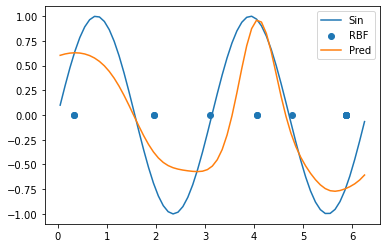

In [58]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=15, delta_epochs=1, cl_epochs=2)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="soft")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

#display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)
